# Visualization and clustering

NOTE: After completing the analysis, a fixed random seed was added to the notebook to ensure reproducible results in future runs. Because the seed was added only after the original experiments had been completed, some numerical outputs (cluster labels, cluster sizes, plots) in the current notebook may differ slightly from the screenshots and interpretations included in the report.
These differences do not affect the methodology or conclusions — the clustering structure remains the same across runs, and only minor numeric values changed. The complete workflow is now fully reproducible for future use.

In [1]:
#libraries

import pandas as pd
import os
import json
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D


import umap

#seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

## 1. Dataset preparation and visualization





Collected datasets/files:
- Million Playlist Dataset: 1000 .json files x 1000 playlists (2017)
- Scraped Playlist Dataset: 76 playlists (2025)
- Million Songs Dataset: ~1.1 mio tracks with audio features



Goal:\
to create a dataset that contains playlists from both 2017 and 2025 playlist datasets, with added audio features for each track to enable better comparisons between tracks for our recommendation system.\
\
Because Spotify Audio Features API is deprecated and data cannot be retrieved from it anymore, I have to rely on the datasets that were made before November 2024, to collect the data about tracks.\
To achieve this, a sample subset of 1000 playlists will be selected from MPD. Coverage of tracks from MSD will be calculated and playlists with a coverage above a certain treshold will be added to the subset. This will limit the amount of missing values.\
The same principle applies to the scraped PD, but I expect the treshold there to be lower, since there are not as many playlists to choose from, and it should be taken into consideration that the songs might be newer and therefore not included in the MSD that was created before their release.\
After selecting the playlists, the .json file will be converted into a .csv file and a subset of scraped playlists will be created, merged together and features added.

### 1.1 Load raw data and create subset

#### Million Song Dataset & MDS Track ID list:

In [ ]:
features_df = pd.read_csv("data/_raw/spotify_data.csv")   # your 1M-song feature dataset
msd_track_ids = set(features_df["track_id"].astype(str))
len(msd_track_ids)

#### Million Playlist Dataset subset

Create a subset of sampled playlists with coverage above a certain threshold (JSON):\
Threshold of 0.75 was chosen after a few trials. It should not be too low to avoid having too many missing values, and not too high - there must be at least one playlist from each file, and we need to be careful to avoid bias, since MSD contains mostly popular songs, which woul eliminate certain playlists with more obscure tracks.

In [ ]:
# --- helper function to determine playlist coverage ---------------

def playlist_coverage(pl):

    tracks = pl.get("tracks", [])
    pl_track_ids = [track["track_uri"].split(":")[-1] for track in tracks]
    matched = sum(1 for tid in pl_track_ids if tid in msd_track_ids)

    return matched / len(pl_track_ids)
    
#---------------------------------------------------------------------


data_dir = "data/_raw/data"   #directory with 1000 MPD files
output_file = "data/mpd_sample_1000.json"

#at least 75% of tracks in a playlist must be able to get audio features from MSD
threshold = 0.75

#list of playlists that fit the criteria - 1 from each file
sampled_playlists = []

#list of files
files = sorted(os.listdir(data_dir))

#reproductibility!!!!!
random.seed(SEED)
np.random.seed(SEED)

for filename in files:
    filepath = os.path.join(data_dir, filename)
    #print(filename)
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
        playlists = data.get('playlists', [])

        #find the first high coverage playlist
        candidates = [pl for pl in playlists if playlist_coverage(pl) >= threshold]
        chosen = random.choice(candidates)
        sampled_playlists.append(chosen)
        #print(playlist_coverage(chosen))

#check length (should be 1000 if all files had at least 1 playlist fit the criteria)
print("Sampled playlists:", len(sampled_playlists))


#save into a new json file
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(sampled_playlists, f, indent=2)






Sampled playlists: 1000


Transform the subset of playlists to a .csv file:

In [ ]:
#read json sample file
with open("data/mpd_sample_1000.json") as f:
    data_json = json.load(f)

#a list of dictionaries (1 dict - 1 track)
rows = []

'''
example of track data: 

"pos": 0,
"artist_name": "G-Eazy",
"track_uri": "spotify:track:40YcuQysJ0KlGQTeGUosTC",
"artist_uri": "spotify:artist:02kJSzxNuaWGqwubyUba0Z",
"track_name": "Me, Myself & I",
"album_uri": "spotify:album:09Q3WwGYsQe5ognkvVkmCu",
"duration_ms": 251466,
"album_name": "When It's Dark Out"

'''

for playlist in data_json:
    playlist_id = playlist["pid"]
    playlist_name = playlist["name"]

    for track in playlist["tracks"]:
        #clean uris
        track_id = track["track_uri"].split(":")[-1]
        artist_id = track["artist_uri"].split(":")[-1]
        album_id = track["album_uri"].split(":")[-1]

        rows.append({
            "playlist_id": playlist_id,
            "playlist_name": playlist_name,
            "artist_id": artist_id,
            "artist_name": track["artist_name"],
            "track_id": track_id,
            "track_name": track["track_name"],
            "album_id": album_id,
            "album_name": track["album_name"],
            "duration_ms": track["duration_ms"],
            "position": track["pos"]
        })

df_json = pd.DataFrame(rows)
df_json.to_csv("data/mpd_playlists.csv", index=False)

df_json.sample(n=5, random_state=SEED)

,playlist_id,playlist_name,artist_id,artist_name,track_id,track_name,album_id,album_name,duration_ms,position
16461,58871,mine.,06HL4z0CvFAxyc27GXpf02,Taylor Swift,5VwFkx7JOimOGTYfha5rs1,I Almost Do,1EoDsNmgTLtmwe1BDAVxV5,Red,242573,122
8578,340423,bet,7iZtZyCzp3LItcw1wtPI3D,Rae Sremmurd,4scpF6J5uMBvoh6sFB7EL1,No Type,6eDx949ONWDCN0O22wFZf7,SremmLife,200080,24
249,107683,Good Country,0BvkDsjIUla7X0k6CSWh1I,Luke Bryan,1PoGWZbJPGmViVi7CYbDUK,Drink A Beer,5M8gr5RV2eR6UkztC69ogB,Crash My Party,202626,55
18437,617005,BRUH,31RyGWziBGfdbaZk9ZSmTE,Max Minelli,3S1o3PmUNYOwoeAPcTxNdF,They Can Hate (feat. Max Minelli),6m6h4C733ycfTkMz5nJJDe,"""I Don't Know What To Call It"" Vol. 1",265812,63
15311,553590,Wedding,29ywwKkxfoH7iWwNY1UezA,Francesca Battistelli,7fSWlTKRsn3jkhe7BiMbIs,Worth It,1s6NqofRkHJN1eThDu948E,Hundred More Years,226213,6


#### Scraped Dataset subset

Check coverage:

In [ ]:
#read file
scraped = pd.read_csv("data/_raw/scraped/spotify_tracks.csv")

#mask column: is each track present in msd
scraped['in_msd'] = scraped['track_id'].apply(lambda x: x in msd_track_ids)

#coverage portion of playlist
coverage_df = (
    scraped.groupby('playlist_id')['in_msd']
           .agg(['sum', 'count'])
           .reset_index()
)

#average per playlist
coverage_df['coverage'] = coverage_df['sum'] / coverage_df['count']

#check range
print("Best coverage: ", np.max(coverage_df['coverage']))
print("Mean coverage: ", np.mean(coverage_df['coverage']))


Best coverage:  0.6507936507936508
Mean coverage:  0.14339813567913973


The coverage of scaped data by MSD is significantly lower than with the MPD. That is because this data is newer and contains songs that were released after MSD was already made, and because scraped data contains only 76 playlists, which is very little to pick from.\
After a few trials I decided on a threshold of 0.15, which is a little bit above average and eliminates the worst 2/3 of the data.


In [ ]:
threshold = 0.15

#get ids of good playlists
good_ids = coverage_df[coverage_df['coverage'] >= threshold]['playlist_id']
print(len(good_ids))

#filter and keep good playlists
scraped_filtered = scraped[scraped['playlist_id'].isin(good_ids)]

#drop mask column
scraped_filtered = scraped_filtered.drop(columns=('in_msd'))

#save new subset to csv
scraped_filtered.to_csv("data/scraped_filtered.csv", index=False)

26


#### Merge both subsets 

In [ ]:
#read files
scraped_subset = pd.read_csv("data/scraped_filtered.csv")
mpd_subset = pd.read_csv("data/mpd_playlists.csv")

#rename to fit mpd column
scraped_subset = scraped_subset.rename(columns={"artists": "artist_name"})

#combine
df_all = pd.concat([scraped_subset, mpd_subset], ignore_index=True)

#fix dtype conflict
df_all['playlist_id'] = df_all['playlist_id'].astype(str)

#save
df_all.to_csv("data/combined_data.csv")

df_all.sample(n=10)

,genre,playlist_id,playlist_name,track_id,track_name,artist_name,artist_id,album_id,album_name,duration_ms,position
27862,NaN,534264,LIT,1wHZx0LgzFHyeIZkUydNXq,Antidote,Travis Scott,0Y5tJX1MQlPlqiwlOH1tJY,4PWBTB6NYSKQwfo79I3prg,Rodeo,262693.0,7.0
33117,NaN,666832,Lord of the Rings,0dlAN15Cr7eIOqhqtFjfHV,The Passing Of Théoden,Howard Shore,0OcclcP5o8VKH2TRqSY2A7,2Re6RMBEfD8iv1HMxLMdzI,The Lord Of The Rings - The Return Of The King...,136320.0,73.0
27240,NaN,52601,Country Favs,6Ymvlzom4TQeoKqAWsZRD8,Somethin' 'Bout A Truck,Kip Moore,2hJPr4lk7Q8SSvCVBl9fWM,191BU6Uvnf7oNTjO4n36Yu,Up All Night,213826.0,9.0
40088,NaN,873452,summer 2015,5w9L4OCR45z7Y0KeKlDVkA,Stand by Your Gun,George Ezra,2ysnwxxNtSgbb9t1m2Ur4j,5tF2lAa2rh2kU2xIiBzWia,Wanted On Voyage,184493.0,3.0
38797,NaN,833674,Luke Bryan Concert,2aYudnZ9lYxIxmhRr1iByK,See About A Girl,Lee Brice,5Zq7R5qmi58ByYyBQTlNuk,0RnVSSUbSBEjk5MlQZhYYP,Hard 2 Love,236960.0,29.0
16568,NaN,198377,HAMILTON,7EsSVPxaYoAZjQwhspJBs2,"Who Lives, Who Dies, Who Tells Your Story",Original Broadway Cast of Hamilton,3UUJfRbrA2nTbcg4i0MOwu,1kCHru7uhxBUdzkm4gzRQc,Hamilton,217229.0,45.0
27254,NaN,52601,Country Favs,0cITLOYn1Sv4q27zZPqlNK,Red,Taylor Swift,06HL4z0CvFAxyc27GXpf02,1EoDsNmgTLtmwe1BDAVxV5,Red,220826.0,23.0
262,rock,29fOXPbR3qClySksICQ2Yn,ROCK MUSIK,2pxAohyJptQWTQ5ZRWYijN,The Trooper - 1998 Remastered Version,NaN,NaN,NaN,NaN,NaN,NaN
31320,NaN,615893,favorite songs,7MbII8jWqFiTFYU3MPYEfW,Rock Me,One Direction,4AK6F7OLvEQ5QYCBNiQWHq,5SxEsi1PNyo1XfEKDYcFKF,Take Me Home: Yearbook Edition,200040.0,33.0
39764,NaN,861267,summer country,7mldq42yDuxiUNn08nvzHO,Body Like A Back Road,Sam Hunt,2kucQ9jQwuD8jWdtR9Ef38,2N7kidh1wA9EoLdf16QWrz,Body Like A Back Road,165386.0,2.0


#### Add the MSD data:
For the overlapping columns the data from playlist datasets has priority.

In [ ]:
features_df = pd.read_csv("data/_raw/spotify_data.csv")
df_all = pd.read_csv("data/combined_data.csv")

#column names check
print(features_df.columns)
print(df_all.columns)

#drop index column
features_df = features_df.drop(columns="Unnamed: 0")
df_all = df_all.drop(columns="Unnamed: 0")

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
Index(['Unnamed: 0', 'genre', 'playlist_id', 'playlist_name', 'track_id',
       'track_name', 'artist_name', 'artist_id', 'album_id', 'album_name',
       'duration_ms', 'position'],
      dtype='object')


In [ ]:
#merge based on track id
merged = df_all.merge(
    features_df,
    on="track_id",
    how="left",
    suffixes=("", "_feat")
)

#filling NAs with info from features df
feat_cols = [c for c in merged.columns if c.endswith("_feat")]
for f in feat_cols:
    base = f[:-5]
    merged[base] = merged[base].fillna(merged[f])

#removing duplicated features
merged = merged.drop(columns=feat_cols)

#added this later - replace genre "hip hop" with "hip-hop"
merged['genre'] = merged['genre'].replace("hip hop", "hip-hop")

merged.to_csv("data/.csv", index=False)

merged.sample(n=10)

### 1.2 Exploratory data analysis of the sampled data set 

In [ ]:
#load sampled data set
df = pd.read_csv("data/sample_merged.csv", low_memory=False)

#### Number of playlists, tracks, artists, genres: 

In [5]:

print(f"Number of rows: {len(df)}")

playlist_col = "playlist_id"
track_col    = "track_id"
artist_col   = "artist_id"
genre_col = "genre"

print(f"Number of unique playlists: {df[playlist_col].nunique()}")
print(f"Number of unique tracks: {df[track_col].nunique()}")
print(f"Number of unique artists: {df[artist_col].nunique()}")
print(f"Number of genres: {df[genre_col].nunique()}")


Number of rows: 44472
Number of unique playlists: 1026
Number of unique tracks: 16393
Number of unique artists: 1812
Number of genres: 60


In [6]:
df[genre_col].unique()

array(['dance', nan, 'country', 'edm', 'hip-hop', 'pop', 'indie-pop',
       'emo', 'hardcore', 'metalcore', 'punk', 'rock', 'electro',
       'gospel', 'dub', 'chill', 'swedish', 'jazz', 'show-tunes', 'house',
       'acoustic', 'k-pop', 'metal', 'alt-rock', 'sleep', 'german',
       'piano', 'hard-rock', 'classical', 'soul', 'drum-and-bass', 'folk',
       'singer-songwriter', 'trance', 'funk', 'club', 'punk-rock',
       'death-metal', 'goth', 'french', 'deep-house', 'disco',
       'minimal-techno', 'power-pop', 'blues', 'breakbeat', 'songwriter',
       'comedy', 'dancehall', 'new-age', 'ambient', 'ska', 'sad',
       'indian', 'groove', 'black-metal', 'psych-rock', 'hardstyle',
       'electronic', 'guitar', 'hip hop'], dtype=object)

#### Missing value distribution and handling:

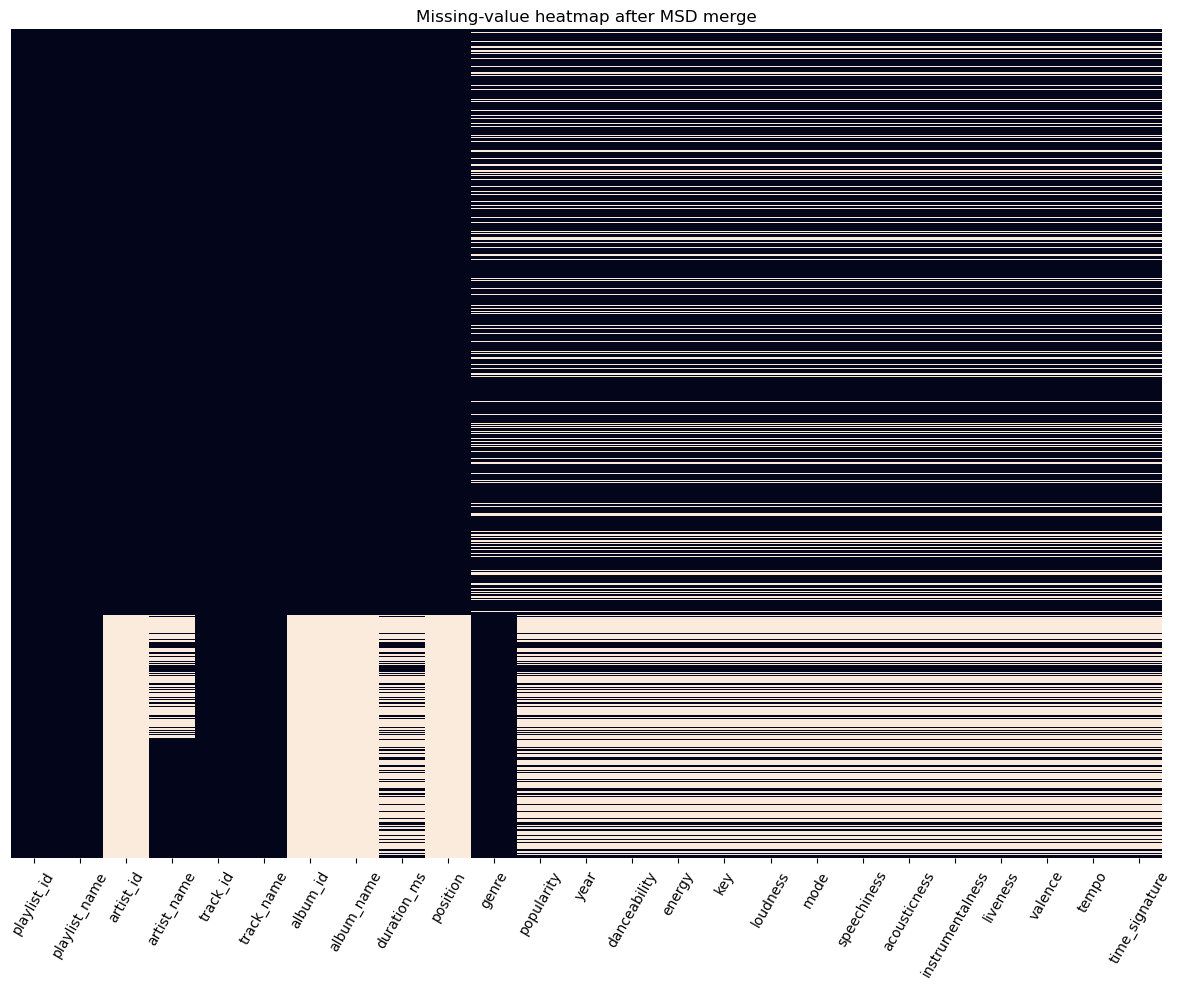

                  missing_count  missing_percent
year                      14954            33.63
danceability              14954            33.63
tempo                     14954            33.63
valence                   14954            33.63
liveness                  14954            33.63
instrumentalness          14954            33.63
acousticness              14954            33.63
speechiness               14954            33.63
mode                      14954            33.63
loudness                  14954            33.63
key                       14954            33.63
energy                    14954            33.63
time_signature            14954            33.63
popularity                14954            33.63
position                  13050            29.34
album_name                13050            29.34
album_id                  13050            29.34
artist_id                 13050            29.34
duration_ms                8869            19.94
genre               

In [7]:
missing_count = df.isna().sum()
missing_percent = df.isna().mean() * 100

missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent.round(2)
}).sort_values("missing_percent", ascending=False)

def plot_missing_values(df, title="Missing-value heatmap after MSD merge"):
    plt.figure(figsize=(12,10))
    sns.heatmap(df.isna(), cbar=False)
    plt.title(title)
    plt.xticks(rotation=60, fontsize=10)
    plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_missing_values(df)
print(missing_summary)

Approximately 33% of all tracks are missing every audio feature.\
Since these features are essential for PCA and clustering, I will proceed with two parallel strategies:

**Dropping Missing-Feature Tracks**\
A second dataset will be created by removing all tracks that lack audio features entirely, ensuring a fully complete dataset for comparison.


**Per-Genre Imputation**\
To preserve as much data as possible, missing audio features will be imputed using the median value within each genre.\
If a track has no valid genre label, the most common genre within its playlist will be used as a fallback.


\
Almost 14% of the tracks are missing genre as well. Since genre information is able to come from either dataset (playlist subset or MSD), it can be assumed that tracks who lack genre lack audio features as well.\
After dropping Missing-Feature tracks, all tracks should have genre.\
Before per-genre imputation, missing values will be filled with the mode genre of the track's playlist.




#### Summary statistics for audio features:

In [8]:
#list of audio features
audio_features = [
    'danceability', 'energy', 'key',
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

#check if all are numerical
df[audio_features].dtypes

#summary statistics
summary_stats = df[audio_features].agg(["mean", "median", "std"]).T
print(summary_stats)

                        mean    median        std
danceability        0.609654    0.6090   0.156048
energy              0.688284    0.7140   0.190969
key                 5.223660    5.0000   3.645743
loudness           -6.300783   -5.7500   3.032534
mode                0.672369    1.0000   0.469357
speechiness         0.119751    0.0580   0.121692
acousticness        0.174601    0.0803   0.221068
instrumentalness    0.027520    0.0000   0.140618
liveness            0.199071    0.1350   0.156264
valence             0.479494    0.4750   0.225224
tempo             124.780383  125.0100  30.151431


Correlation heatmap of audio features:

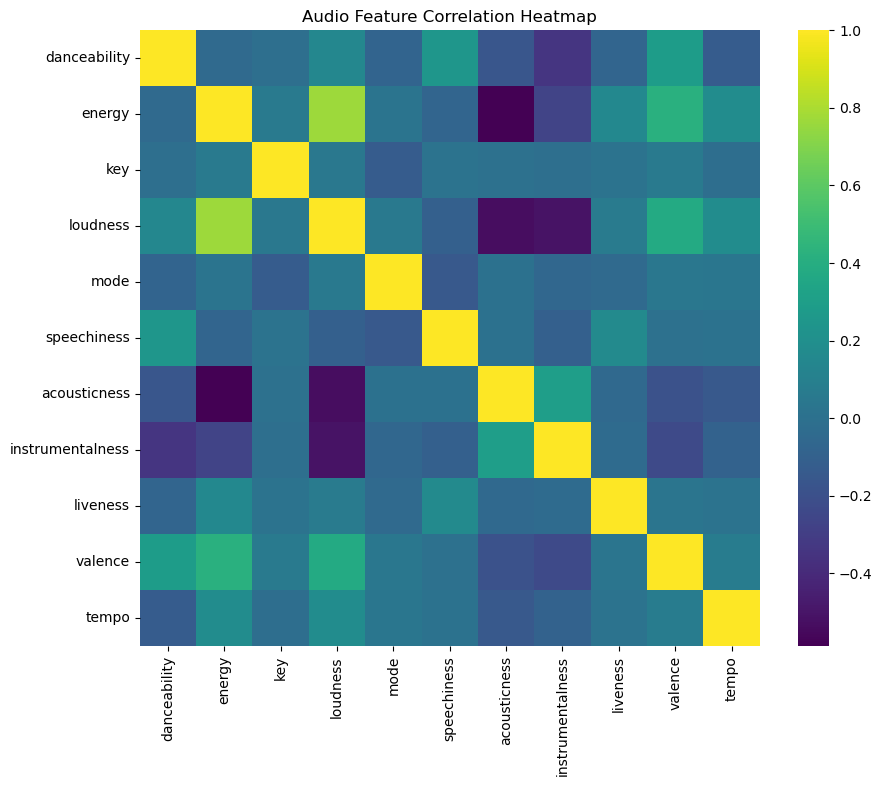

In [9]:
def plot_audio_correlations(df, audio_cols):
    plt.figure(figsize=(10,8))
    corr = df[audio_cols].corr()
    sns.heatmap(corr, cmap="viridis", annot=False)
    plt.title("Audio Feature Correlation Heatmap")
    plt.show()

plot_audio_correlations(df, audio_features)

Distribution plots for audio features:

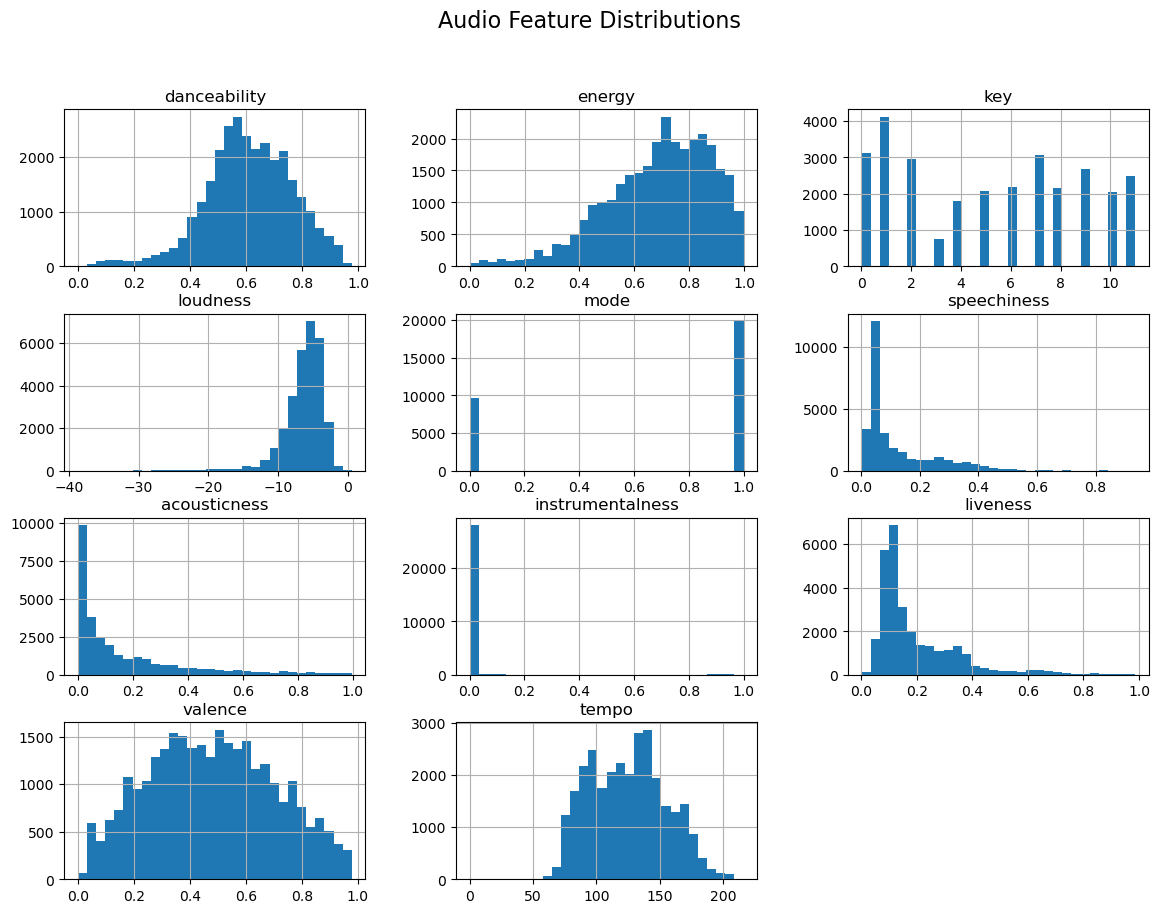

In [10]:
def plot_audio_distributions(df, audio_cols):
    df[audio_cols].hist(figsize=(14,10), bins=30)
    plt.suptitle("Audio Feature Distributions", fontsize=16)
    plt.show()

plot_audio_distributions(df, audio_features)

#### Genre distribution

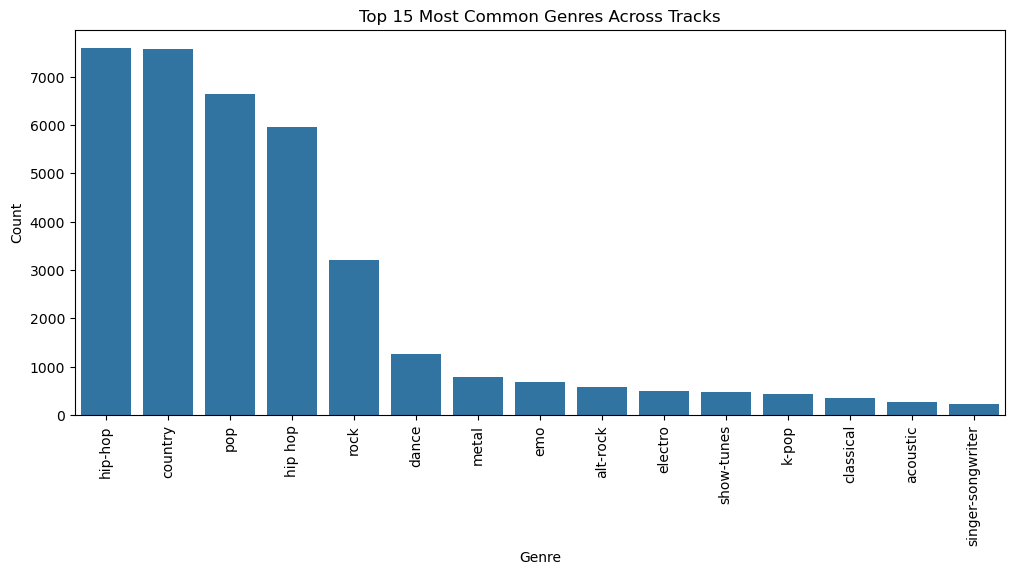

In [11]:
def plot_top_genres(df, n=15):
    plt.figure(figsize=(12, 5))

    #get top n genres
    top = df['genre'].value_counts().head(n).index

    sns.countplot(
        data= df[df['genre'].isin(top)],
        x='genre',
        order=top
    )

    plt.xticks(rotation=90)
    plt.title(f"Top {n} Most Common Genres Across Tracks")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.show()

plot_top_genres(df, 15)

This shows that sampled data is very biased, which will likely affect clustering and further analysis. This happened because MSD covers mainly hip-hop and popular tracks.\
Hip-hop accounts for more than 1/3 of the data.\
To fix this, genres will be normalized at playlist level, which will hopefully enable playlist composition to be presented in the clusters.

Another option would be to downsample hip-hop tracks for clustering. However, that is not a realistic approach for building a recommender.

#### Playlist titles statistics

Playlist name lengths:

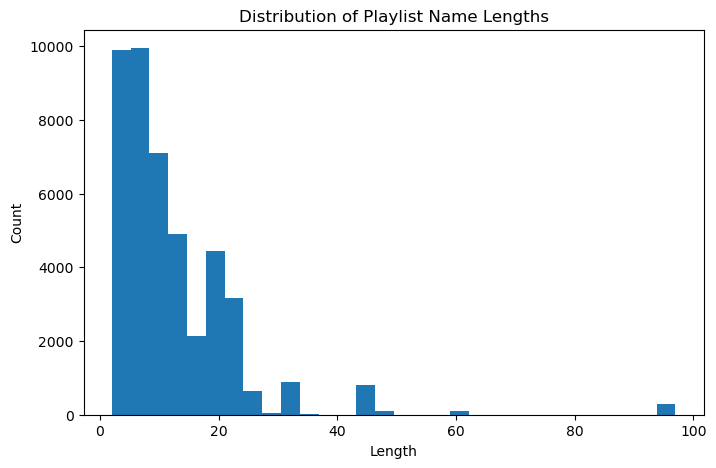

In [12]:
def plot_playlist_name_lengths(df):
    lengths = df['playlist_name'].apply(len)
    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=30)
    plt.title("Distribution of Playlist Name Lengths")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()

plot_playlist_name_lengths(df)

Common playlist title words:

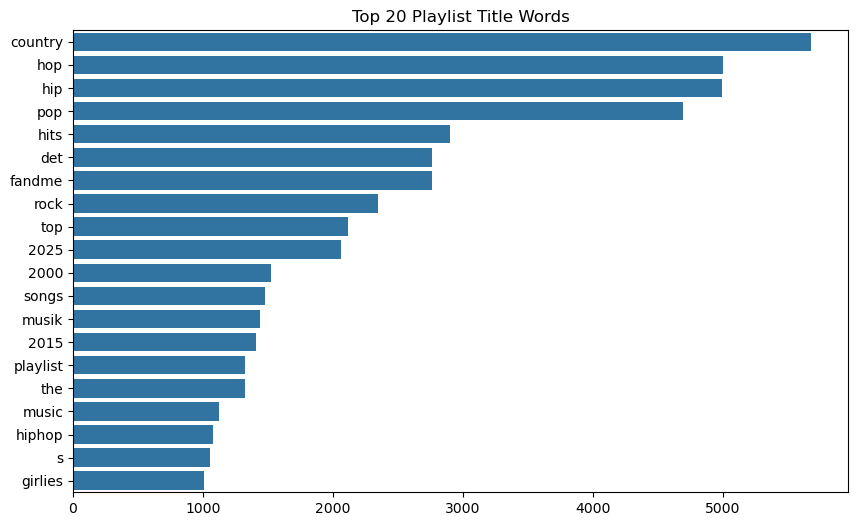

In [13]:
def plot_common_playlist_words(df, n=20):
    names = df['playlist_name'].dropna().str.lower()
    words = re.findall(r'\w+', " ".join(names))
    
    counter = Counter(words)
    most = counter.most_common(n)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=[c[1] for c in most], y=[c[0] for c in most])
    plt.title(f"Top {n} Playlist Title Words")
    plt.show()

plot_common_playlist_words(df, 20)

Common artists:

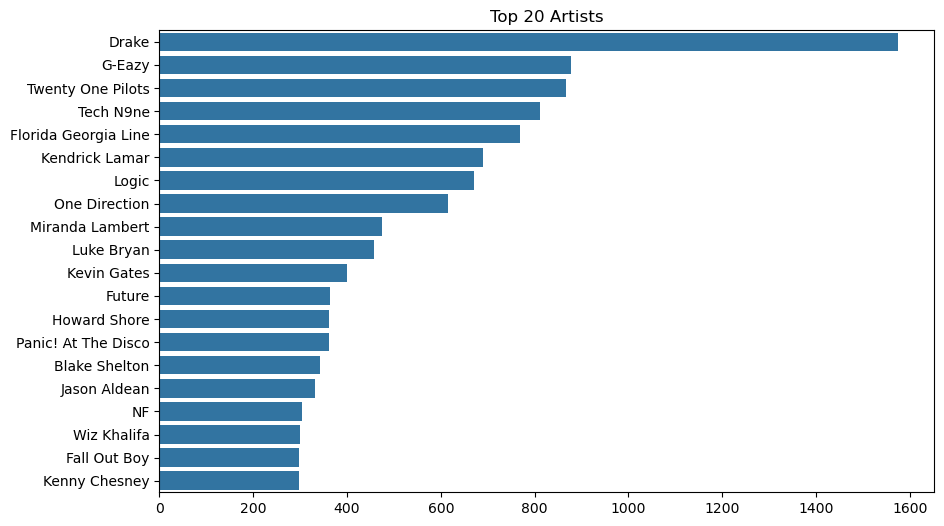

In [14]:
def plot_common_artists(df, n=20):
    artists = df['artist_name'].dropna()
    counter = Counter(artists)
    most = counter.most_common(n)

    plt.figure(figsize=(10,6))
    sns.barplot(x=[c[1] for c in most], y=[c[0] for c in most])
    plt.title(f"Top {n} Artists")
    plt.show()

plot_common_artists(df, 20)

### 1.3 The three analysis datasets

#### Dataset with dropped NAs

In [15]:
def create_dropna_dataset(df, cols, audio_features):
    df = df[cols]
    return df.dropna(subset=cols).copy()

cols = ['playlist_id', 'genre'] + audio_features
df_drop = create_dropna_dataset(df, cols, audio_features)

df_drop.to_csv("data/data_audio_dropped.csv")


OSError: Cannot save file into a non-existent directory: 'data'

#### Dataset with imputed values (per-genre)

In [ ]:
#calculating global medians
global_medians = {}

#select only genre + audio columns
audio_df = df[cols]

for c in audio_features:
    med = audio_df[c].median(skipna=True)
    global_medians[c] = med

#print(global_medians)

#calculating per-genre medians
genres = audio_df['genre'].unique()
genre_medians = audio_df.groupby('genre')[audio_features].median()

#print(genre_medians.sample(n=5))

#find mode of genre per playlist and fill missing genre values
num_missing_genre = audio_df['genre'].isna().sum()
#print(num_missing_genre)

playlist_genre_mode = (audio_df.groupby('playlist_id')['genre'].agg(lambda x: x.mode()[0]))
#print(playlist_genre_mode.sample(n=5))

#fill missing genres in tracks
df_imp = audio_df.merge(playlist_genre_mode.rename("playlist_genre"), 
                    on="playlist_id", how='left')
df_imp['genre'] = df_imp['genre'].fillna(df_imp['playlist_genre'])
df_imp = df_imp.drop(columns=['playlist_genre'])
#df_imp.sample(n=5)

#fill missing audio features in tracks based on genre
for c in audio_features:
    df_imp[c] = df_imp[c].fillna(
        df_imp['genre'].map(genre_medians[c])
    )

#verify no missing values
df_imp.isna().sum().sum()

df_imp.to_csv("data/data_audio_imputed.csv")

#### Dataset with text

In [ ]:
df.columns
text_cols = ['playlist_id', 'playlist_name', 'track_name', 'artist_name', 'album_name'] 
df_text = df[text_cols]
df_text.to_csv("data/data_text.csv")

#### 1.4 Per-playlist feature aggregation:

Audio + genre:

In [ ]:
#PLAYLIST-LEVEL FEATURE AGGREGATION
def aggregate_playlists(df):
    
    playlist_id = "playlist_id"
    track_id = "track_id"
    num_audio_cols = ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']
    genre = "genre"
    
    #numeric aggregation
    mean_df = df.groupby(playlist_id)[num_audio_cols].mean()
    mean_df.columns = [f"{c}_mean" for c in mean_df.columns]
    
    #genre proportion in a playlist: one-out-of-K encoding
    genre_dummies = pd.get_dummies(df[genre], prefix="genre")
    genre_df = pd.concat([df[[playlist_id]], genre_dummies], axis=1)
    genre_props = genre_df.groupby(playlist_id).mean()

    #print(genre_props.sample(n=5))

    #join
    playlist_features = (
        mean_df
        .join(genre_props, how="left")
    )

    #print(playlist_features.columns)

    return playlist_features

df_imp = pd.read_csv("data/data_audio_imputed.csv")
df_drop = pd.read_csv("data/data_audio_dropped.csv")

aggr_imp = aggregate_playlists(df_imp)
aggr_drop = aggregate_playlists(df_drop)

aggr_imp.to_csv("data/audio_imputed_aggr.csv")
aggr_drop.to_csv("data/audio_dropped_aggr.csv")

aggr_imp.sample(n=5, random_state=SEED)


,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,...,genre_sertanejo,genre_show-tunes,genre_singer-songwriter,genre_ska,genre_sleep,genre_songwriter,genre_soul,genre_swedish,genre_trance,genre_trip-hop
playlist_id,,,,,,,,,,,,,,,,,,,,,
7xkmRjcU7adwvRRtdHCLGr,0.663382,0.700384,5.190099,-5.477107,0.811881,0.067172,0.118448,0.001049,0.144197,0.545555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56193,0.539298,0.721596,5.382979,-5.650511,0.957447,0.039085,0.151708,0.004229,0.167870,0.524819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179246,0.586619,0.801238,4.000000,-4.984190,0.857143,0.042243,0.114382,0.000014,0.198200,0.708333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901344,0.694833,0.620083,5.750000,-6.407000,0.750000,0.108317,0.144511,0.001017,0.137983,0.474667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337818,0.706611,0.570111,3.277778,-7.126889,0.611111,0.269150,0.222877,0.000197,0.223261,0.371833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Clustering

### 2.1 Audio based clustering

Clustering based on audio features will be done in parallel with both the imputed and the dropped NAs version of the data sets. At the end results will be evaluated based on which data set performs better and yields more reasonable results.

#### Preparation

Load data:

In [ ]:
df_imp_all = pd.read_csv("data/audio_imputed_aggr.csv")
df_drop_all = pd.read_csv("data/audio_dropped_aggr.csv")

#remove columns with genre - need only audio features for this clustering
genre_cols = [col for col in df_imp_all.columns if col.startswith("genre_")]
df_imp = df_imp_all.drop(columns=genre_cols)
df_drop = df_drop_all.drop(columns=genre_cols)


df_imp.sample(n=5, random_state=SEED)

,playlist_id,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,tempo_mean
803,7xkmRjcU7adwvRRtdHCLGr,0.663382,0.700384,5.190099,-5.477107,0.811881,0.067172,0.118448,0.001049,0.144197,0.545555,122.808123
523,56193,0.539298,0.721596,5.382979,-5.650511,0.957447,0.039085,0.151708,0.004229,0.167870,0.524819,135.092936
89,179246,0.586619,0.801238,4.000000,-4.984190,0.857143,0.042243,0.114382,0.000014,0.198200,0.708333,127.383524
916,901344,0.694833,0.620083,5.750000,-6.407000,0.750000,0.108317,0.144511,0.001017,0.137983,0.474667,113.930667
270,337818,0.706611,0.570111,3.277778,-7.126889,0.611111,0.269150,0.222877,0.000197,0.223261,0.371833,133.150389


Scaling:

In [ ]:
def scale_features(df, feature_cols):

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df[feature_cols])
    
    #array -> df
    df_scaled = pd.DataFrame(scaled_array, 
                             columns=feature_cols, 
                             index=df.index)
    
    #make a scaled full df
    df_scaled_full = pd.concat([df.drop(columns=feature_cols), df_scaled], axis=1)
    
    return df_scaled_full

cols = df_drop.columns[1:].to_list()
df_imp_scaled = scale_features(df_imp, cols)
df_drop_scaled = scale_features(df_drop, cols)

df_imp_scaled.sample(n=5, random_state=SEED)

,playlist_id,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,tempo_mean
803,7xkmRjcU7adwvRRtdHCLGr,0.390495,0.256414,-0.136774,0.427093,0.502092,-0.637327,-0.361160,-0.225068,-0.678755,0.781270,-0.187979
523,56193,-0.755674,0.426233,0.080950,0.359344,1.359916,-1.010366,-0.113905,-0.199667,-0.217226,0.596991,1.106156
89,179246,-0.318567,1.063847,-1.480163,0.619675,0.768821,-0.968426,-0.391388,-0.233334,0.374084,2.227857,0.294014
916,901344,0.681010,-0.386472,0.495245,0.063784,0.137423,-0.090863,-0.167411,-0.225318,-0.799901,0.151293,-1.123168
270,337818,0.789802,-0.786548,-2.295411,-0.217476,-0.681054,2.045254,0.415171,-0.231868,0.862676,-0.762573,0.901520


PCA and plot check before clustering:

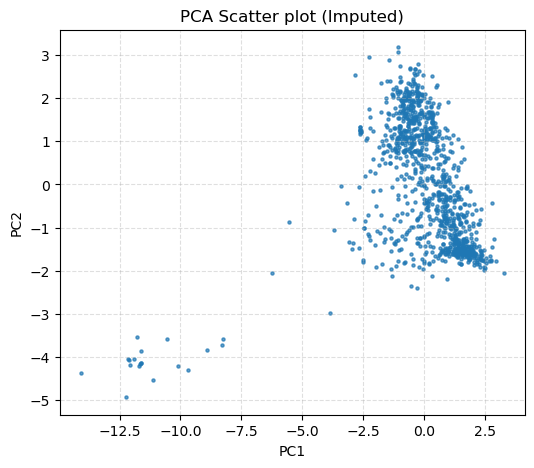

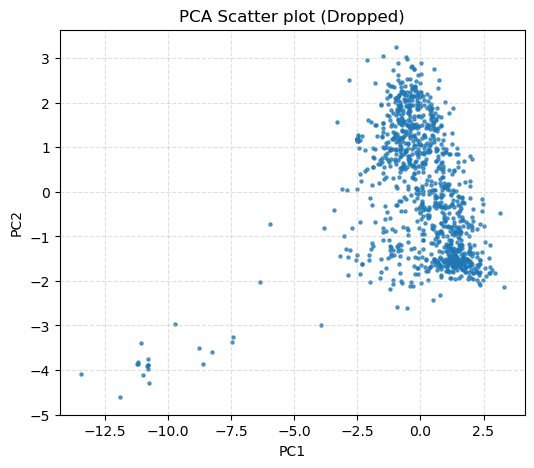

In [ ]:
#PCA reduction
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
    #return data frame and pca model 
    return X_pca_df, pca

#PCA variance plot before clustering
def pca_plot(X_pca_df, tip, labels=None):
    plt.figure(figsize=(6, 5))
    
    if labels is None:
        plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], s=5, alpha=0.7)
    else:
        #encode labels
        le = LabelEncoder()
        labels_enc = le.fit_transform(labels)
        plt.scatter(
            X_pca_df['PC1'], X_pca_df['PC2'], 
            c=labels_enc, cmap='viridis', s=5, alpha=0.8
        )
        
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA Scatter plot ({tip})")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

#imputed
X_imp = df_imp_scaled.drop(columns=['playlist_id'])
X_pca_imp, _ = apply_pca(X_imp, n_components=3)
pca_plot(X_pca_imp, tip="Imputed")

#dropped
X_drop = df_drop_scaled.drop(columns=['playlist_id'])
X_pca_drop, _ = apply_pca(X_drop, n_components=3)
pca_plot(X_pca_drop, tip="Dropped")



#### Clustering 1: K-means and PCA -> K-means

In [ ]:
#KMEANS
def run_kmeans(X, k):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return labels, sil, db, kmeans

#score plot
def plot_scores(results_dict, metric_name="Silhouette Score"):
    ks = list(results_dict.keys())
    scores = [results_dict[k] for k in ks]

    plt.figure(figsize=(6, 5))
    plt.plot(ks, scores, marker='o')
    plt.xlabel("k")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} vs k")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

#centroid heatmap
def plot_centroid_heatmap(centroids, title="Cluster Centroid Heatmap"):
    plt.figure(figsize=(8, 4))
    sns.heatmap(centroids, annot=False, cmap="viridis")
    plt.title(title)
    plt.show()

#cluster summary by genres
def genre_cluster_summary(df_all, labels):

    #select genre columns
    genre_cols = [c for c in df_all.columns if c.startswith("genre_")]
    
    #copy and add cluster labels
    df_tmp = df_all.copy()
    df_tmp['cluster'] = labels
    
    #mean per cluster
    cluster_means = df_tmp.groupby('cluster')[genre_cols].mean()
    
    #remove 'genre_' prefix
    cluster_means.columns = [c.replace('genre_', '') for c in cluster_means.columns]
    
    #keep only top 5 genres per cluster
    top5_dict = {}
    for cluster_id, row in cluster_means.iterrows():
        row_clean = row.dropna()
        top5 = row_clean.nlargest(10)
        top5_dict[cluster_id] = list(top5.items())
    
    return top5_dict


#pipeline
def kmeans_pipeline(X, df_all, k_range=range(3, 11), drop_cols=['playlist_id'], plot_pca=True, pca_data=False):
    
    # run k-means for multiple k
    results_sil = {}
    results_db = {}
    models = {}
    labels_dict = {}
    
    for k in k_range:
        labels, sil, db, model = run_kmeans(X, k)
        print(f"K:{k}, SIL:{sil:.3f}, DB:{db:.3f}")
        results_sil[k] = sil
        results_db[k] = db
        models[k] = model
        labels_dict[k] = labels
    
    # plot silhouette and DB scores
    plot_scores(results_sil, metric_name="Silhouette Score")
    plot_scores(results_db, metric_name="Davies-Bouldin Score")
    
    # pick best k based on silhouette
    best_k = max(results_sil, key=results_sil.get)
    best_labels = labels_dict[best_k]
    best_model = models[best_k]
    print(f"Best k based on silhouette: {best_k}")
    
    # PCA for plotting 
    if plot_pca:
        X_pca_df, _ = apply_pca(X, n_components=2)
        pca_plot(X_pca_df, tip=f"k={best_k}", labels=best_labels)
    
    #centroids
    if pca_data == False:
        centroids = best_model.cluster_centers_    
        centroids_df = pd.DataFrame(centroids, columns=[c for c in X.columns if c != 'playlist_id'])
        plot_centroid_heatmap(centroids_df)
        print(centroids_df)

    #genre summary
    genre_summary = genre_cluster_summary(df_all, best_labels)
    for c, it in genre_summary.items():
        print(f"Cluster {c}:")
        for x in it:
            print(f"{x[0]}, {x[1]:.3f}")
        print()

    # return results
    return {
        "best_k": best_k,
        "best_labels": best_labels,
        "best_model": best_model,
        "silhouette_scores": results_sil,
        "db_scores": results_db,
        "genre_summary": genre_summary
    }


K-means on original feature space:

K:3, SIL:0.271, DB:1.213
K:4, SIL:0.273, DB:1.382
K:5, SIL:0.269, DB:1.488
K:6, SIL:0.271, DB:1.305
K:7, SIL:0.236, DB:1.340
K:8, SIL:0.231, DB:1.240
K:9, SIL:0.222, DB:1.308
K:10, SIL:0.182, DB:1.411


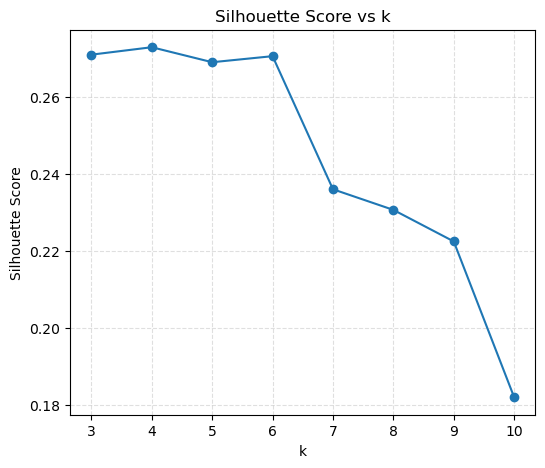

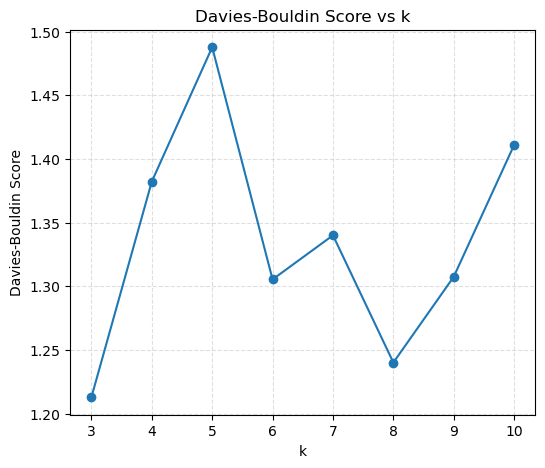

Best k based on silhouette: 4


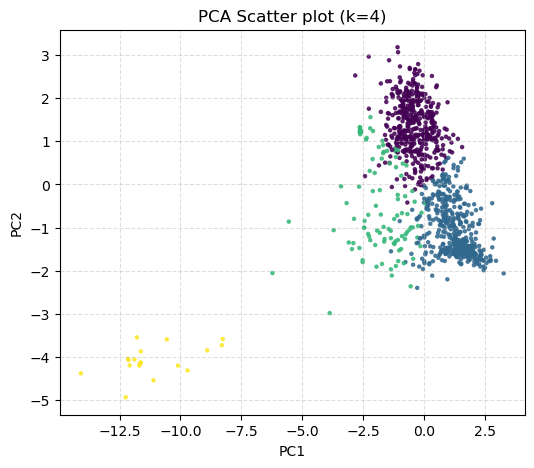

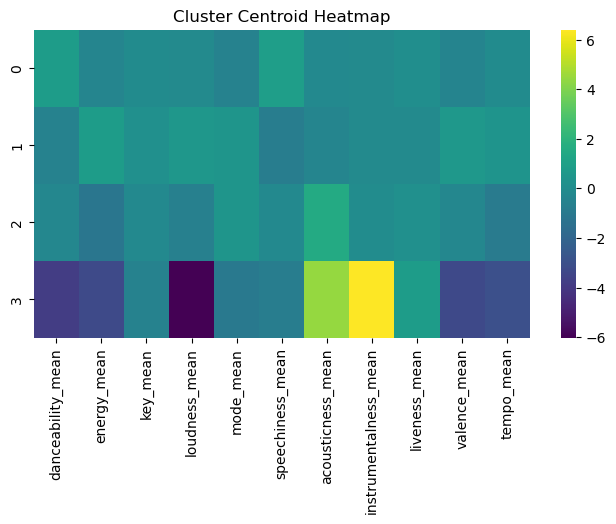

   danceability_mean  energy_mean  key_mean  loudness_mean  mode_mean  \
0           0.775797    -0.380103 -0.105654      -0.131310  -0.517638   
1          -0.533640     0.771365  0.163746       0.527033   0.446575   
2          -0.285341    -1.147558 -0.162066      -0.641472   0.440179   
3          -3.826571    -3.248574 -0.554182      -6.021478  -0.999506   

   speechiness_mean  acousticness_mean  instrumentalness_mean  liveness_mean  \
0          0.883514          -0.173079              -0.153113       0.043861   
1         -0.790802          -0.370037              -0.112461      -0.111907   
2         -0.168348           1.541663              -0.017638       0.156546   
3         -0.829727           4.423959               6.390658       0.791057   

   valence_mean  tempo_mean  
0     -0.421285   -0.087779  
1      0.611116    0.416053  
2     -0.269436   -0.893386  
3     -3.288692   -2.987639  
Cluster 0:
hip-hop, 0.740
dance, 0.101
pop, 0.042
electro, 0.023
emo, 0.014
house, 

In [ ]:
#imputed
results_imp = kmeans_pipeline(X_imp, df_imp_all)

K:3, SIL:0.246, DB:1.299
K:4, SIL:0.242, DB:1.477
K:5, SIL:0.188, DB:1.605
K:6, SIL:0.200, DB:1.523
K:7, SIL:0.189, DB:1.559
K:8, SIL:0.167, DB:1.480
K:9, SIL:0.187, DB:1.417
K:10, SIL:0.177, DB:1.499


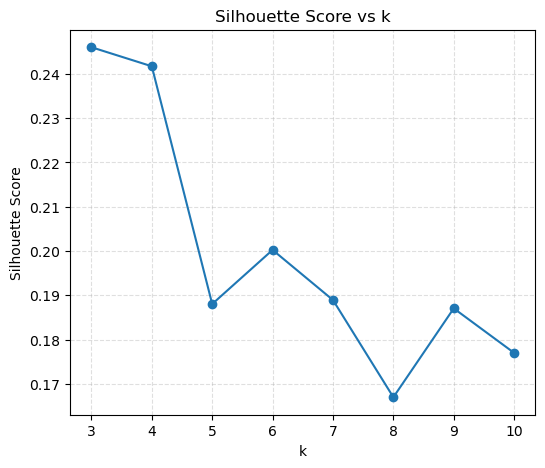

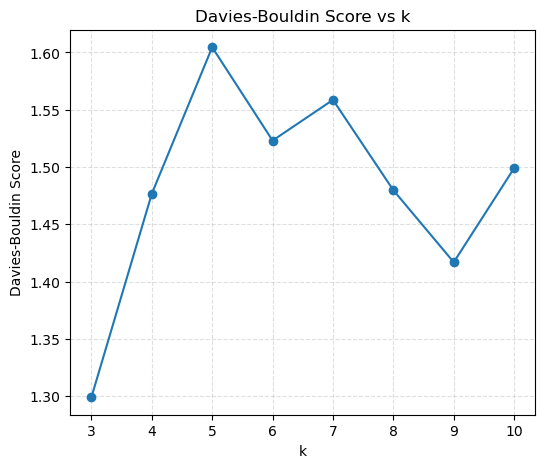

Best k based on silhouette: 3


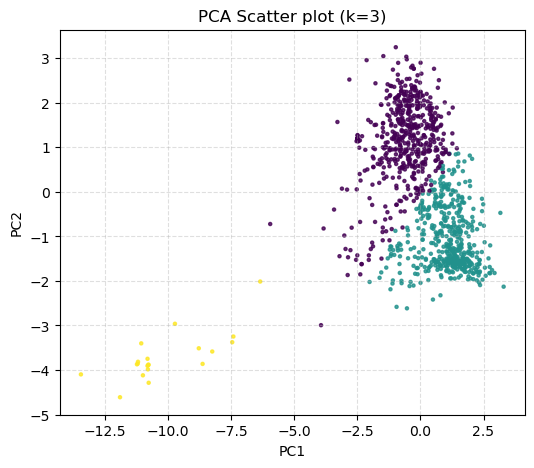

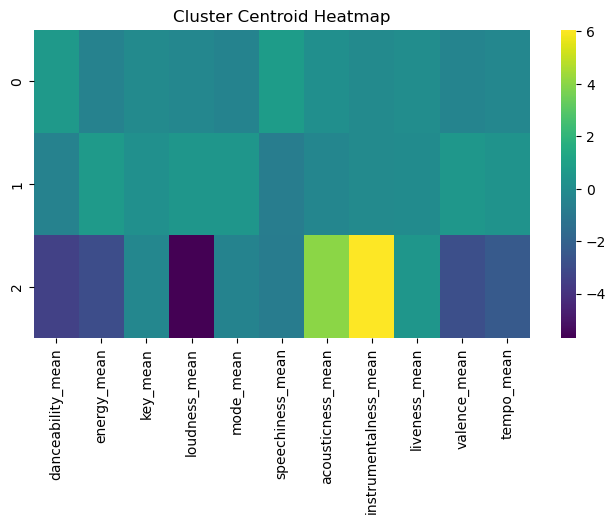

   danceability_mean  energy_mean  key_mean  loudness_mean  mode_mean  \
0           0.629153    -0.516805 -0.130333      -0.234468  -0.450311   
1          -0.531777     0.674429  0.149788       0.485164   0.499210   
2          -3.435811    -2.951672 -0.251189      -5.693318  -0.422729   

   speechiness_mean  acousticness_mean  instrumentalness_mean  liveness_mean  \
0          0.741364           0.116745              -0.135884       0.028101   
1         -0.759251          -0.290964              -0.104002      -0.050678   
2         -0.825660           4.035040               6.060214       0.500851   

   valence_mean  tempo_mean  
0     -0.371930   -0.240744  
1      0.515564    0.357107  
2     -2.858044   -2.418358  
Cluster 0:
hip-hop, 0.635
dance, 0.100
pop, 0.076
show-tunes, 0.024
electro, 0.018
emo, 0.015
house, 0.014
singer-songwriter, 0.014
rock, 0.012
indie-pop, 0.012

Cluster 1:
country, 0.421
alt-rock, 0.106
rock, 0.102
pop, 0.076
dance, 0.075
metal, 0.033
emo, 0.032
hi

In [ ]:
#dropped
results_drop = kmeans_pipeline(X_drop, df_drop_all)

K-means on PCA-reduced space:

K:3, SIL:0.442, DB:0.744
K:4, SIL:0.436, DB:0.817
K:5, SIL:0.439, DB:0.869
K:6, SIL:0.374, DB:0.901
K:7, SIL:0.311, DB:1.016
K:8, SIL:0.325, DB:0.900
K:9, SIL:0.313, DB:0.944
K:10, SIL:0.306, DB:0.978


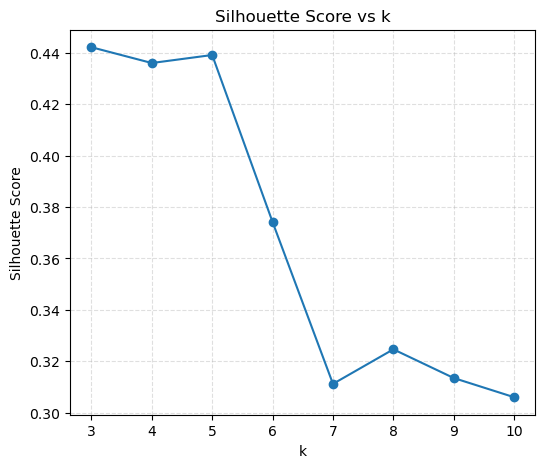

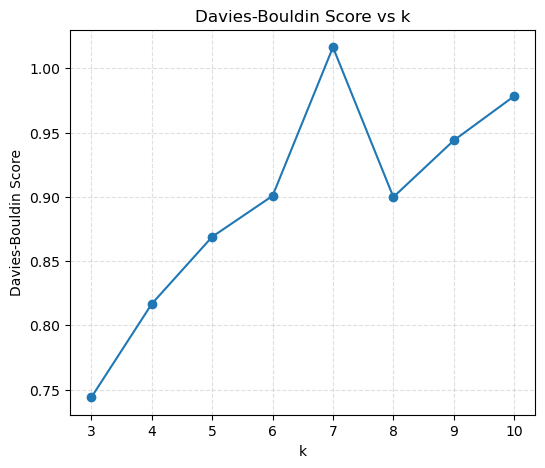

Best k based on silhouette: 3


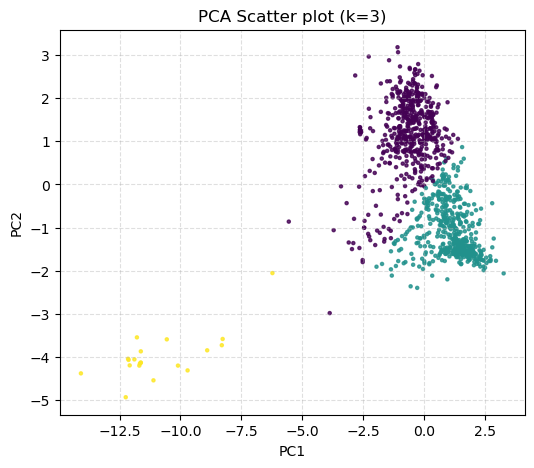

Cluster 0:
hip-hop, 0.650
dance, 0.096
pop, 0.068
show-tunes, 0.025
electro, 0.023
singer-songwriter, 0.016
emo, 0.014
house, 0.012
indie-pop, 0.012
rock, 0.010

Cluster 1:
country, 0.431
alt-rock, 0.110
rock, 0.104
pop, 0.078
dance, 0.078
metal, 0.034
emo, 0.032
hip-hop, 0.016
electro, 0.015
k-pop, 0.013

Cluster 2:
classical, 0.471
sleep, 0.284
new-age, 0.109
german, 0.050
folk, 0.049
metal, 0.017
piano, 0.014
singer-songwriter, 0.003
pop, 0.001
goth, 0.001



In [ ]:
#imputed
results_imp_pca = kmeans_pipeline(X_pca_imp, df_imp_all, pca_data=True)

K:2, SIL:0.372, DB:1.124
K:3, SIL:0.413, DB:0.800
K:4, SIL:0.394, DB:0.858
K:5, SIL:0.401, DB:0.911
K:6, SIL:0.324, DB:1.016
K:7, SIL:0.323, DB:0.961
K:8, SIL:0.326, DB:0.865
K:9, SIL:0.329, DB:0.903


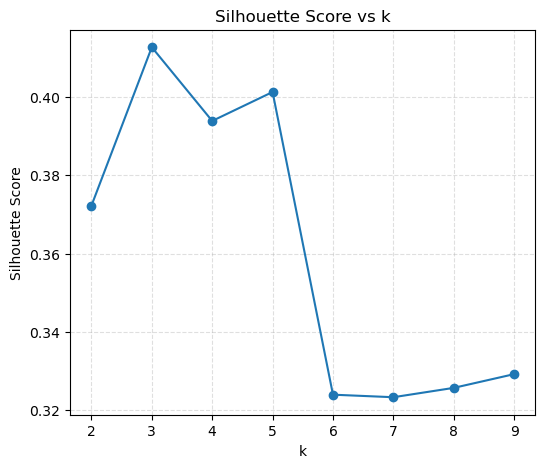

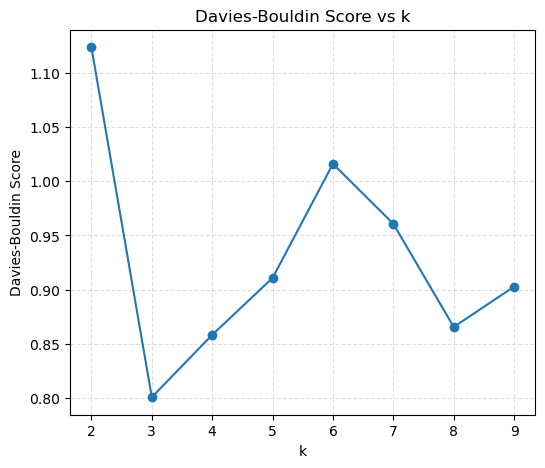

Best k based on silhouette: 3


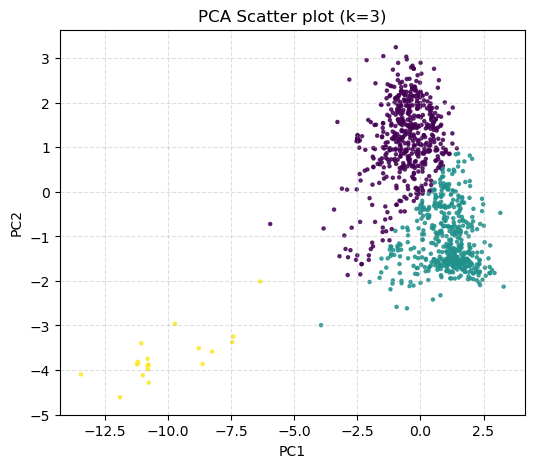

Cluster 0:
hip-hop, 0.632
dance, 0.102
pop, 0.074
show-tunes, 0.024
electro, 0.019
emo, 0.015
house, 0.014
singer-songwriter, 0.014
rock, 0.013
indie-pop, 0.013

Cluster 1:
country, 0.423
alt-rock, 0.105
rock, 0.101
pop, 0.078
dance, 0.073
metal, 0.033
emo, 0.032
hip-hop, 0.025
electro, 0.019
k-pop, 0.013

Cluster 2:
classical, 0.464
sleep, 0.282
new-age, 0.112
german, 0.050
folk, 0.048
metal, 0.019
piano, 0.017
singer-songwriter, 0.004
goth, 0.002
pop, 0.002



In [ ]:
#dropped
results_drop_pca = kmeans_pipeline(X_pca_drop, df_drop_all, pca_data=True, k_range=range(2, 10))

**Results**


**1. Imputed Audio Features (Full Feature Space)**

(Most expressive but noisy due to imputation)

The imputed, non-reduced clustering produced four clusters, that most differ from each other in acousticness, energy, loudness, and instrumentalness.

Cluster A — Pop / Acoustic / Show-Tunes

This cluster shows moderate acousticness and moderate energy but lacks extreme values. Genre distribution includes pop (18.4%), show-tunes (16.7%), hip-hop (12.8%), and a broad mix of acoustic and folk genres. The lack of strong acoustic signatures indicates a heterogeneous, mixed-purpose playlist group, likely blending mainstream pop with lighter acoustic tracks.

Cluster B — Energetic: Country / Rock / Pop

This cluster has high energy, high loudness, and high valence, characteristic of upbeat, amplified music. Genres align with this: country (45.7%), rock (9.7%), alt-rock (9.5%), and dance (8.8%).

Cluster C — Hip-Hop / Dance / Electronic

Highest danceability and highest speechiness, this cluster captures playlists dominated by hip-hop (70.2%), with supporting roles from dance (10.2%) and electronic genres. The acoustic profile (low acousticness, moderately loud, rhythmic) matches the trap / rap / club music sound profile.

Cluster D — Classical / Ambient / Instrumental

The most distinct cluster, defined by extremely low danceability, very low energy, very negative loudness, and very high acousticness and instrumentalness. Genre distribution confirms: classical (50.3%), sleep/ambient (28.9%), and piano/new-age music dominate. This cluster represents quiet, instrumental playlists used for studying, relaxing, or background ambience.

Interpretation:
All four clusters are coherent and musically meaningful. However, the mixed nature of Cluster A indicates some noise introduced by imputation, which blurs boundaries between pop/acoustic/hip-hop playlists. Could it indicate overfitting?

**2. Dropped-NA Audio Features (Full Feature Space)**

(Cleaner structure, fewer playlists, stronger clusters)

When removing tracks with missing audio features, three clear and stable clusters appear.

Cluster 0 — Classical / Ambient / Instrumental

Similar to Cluster D above, this group contains extremely low-energy, quiet, instrumental playlists. Genres confirm: classical (41.1%), sleep (23.1%), folk, French acoustic, and piano/new-age.
This cluster is the most homogeneous across all models.

Cluster 1 — Country / Rock / Pop (High Energy)

The energetic, major-key playlists again form a strong cluster. The dominant genres (country 43.0%, pop, alt-rock, dance) match the audio profile of high-energy and loud modern mainstream music.

Cluster 2 — Hip-Hop / Dance

The danceable, speech-heavy playlists again form a stable cluster dominated by hip-hop (59.0%), dance, pop, and electro. Audio features (high speechiness, high danceability) reinforce this.

Interpretation:
Dropping NA values improves cluster clarity and creates tighter, more musically consistent groups. Compared to the imputed model, no noisy mixed-pop cluster appears; the structure becomes cleaner.

**3 & 4. PCA-Reduced Models (Imputed + Dropped NA)**

(Very clean grouping, but acoustic interpretability limited)

Using PCA to compress audio features into principal components produces three very clean and visually well-separated clusters, but interpretability of centroids decreases because PCA mixes features into abstract linear combinations.
However, the genre composition of each cluster remains extremely stable and matches the non-reduced solutions:

Cluster A — Classical / Ambient / Instrumental\
Cluster B — Country / Rock / Pop\
Cluster C — Hip-Hop / Dance / Electronic

These clusters replicate the three dominant archetypes found previously, confirming that the structure is not dependent on missing values or high dimensionality.

Interpretation:
The PCA clustering is visually the cleanest and most balanced. However, it sacrifices the ability to explain clusters directly in terms of audio features, which weakens interpretability.



| Model               | Clarity  | Interpretability | Stability | Comments                                   |
| ------------------- | -------- | ---------------- | --------- | ------------------------------------------ |
| Imputed (no PCA)    | Medium   | High             | OK        | 4 clusters but one is noisy/mixed          |
| Dropped NA (no PCA) | High     | High             | High      | Clear clusters + good interpretability     |
| Imputed PCA         | High     | Low              | Medium    | Clean, but audio meaning lost              |
| Dropped PCA         | High     | Low              | High      | Best visually; weak interpretability       |


#### Clustering 2: Hierarchical clustering

I chose agglomerative clustering for the next option because it does not require a predefined number of clusters and builds a gull clustering tree which allows us to inspect the structure of the data, see natural separations and choose number of clusters after that. Valuable, since playlist audio distributions do not form obvious clusters.

Our final similarity matrix of 1026 playlists is also small enough for this to be computationally feasible.

DBSCAN in this case would not work very well, because our clusters are continuous and overlapping and there is no individual dense blobs, only one continuous blob and large empty regions. Interpreting the clusters would also be very difficult.

In [ ]:
def hierarchical_clustering(X):
    # linkage: how clusters merge. 'ward' works best for numeric, scaled data
    Z = linkage(X, method='ward')

    plt.figure(figsize=(14, 6))
    plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
    plt.xlabel("Playlist index")
    plt.ylabel("Distance")
    dendrogram(Z, truncate_mode='level', p=6)  # shows only the top merges for clarity
    plt.show()

def plot_pca_agg(X, n_clusters):
    agg = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward'
    )

    clusters_agg = agg.fit_predict(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for cluster_id in sorted(set(clusters_agg)):
        mask = clusters_agg == cluster_id
        plt.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            s=20,
            label=f"Cluster {cluster_id}"
        )
    plt.title("Agglomerative Clustering (PCA 2D projection)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    #plt.legend(title="Cluster")
    plt.show()

Imputed:

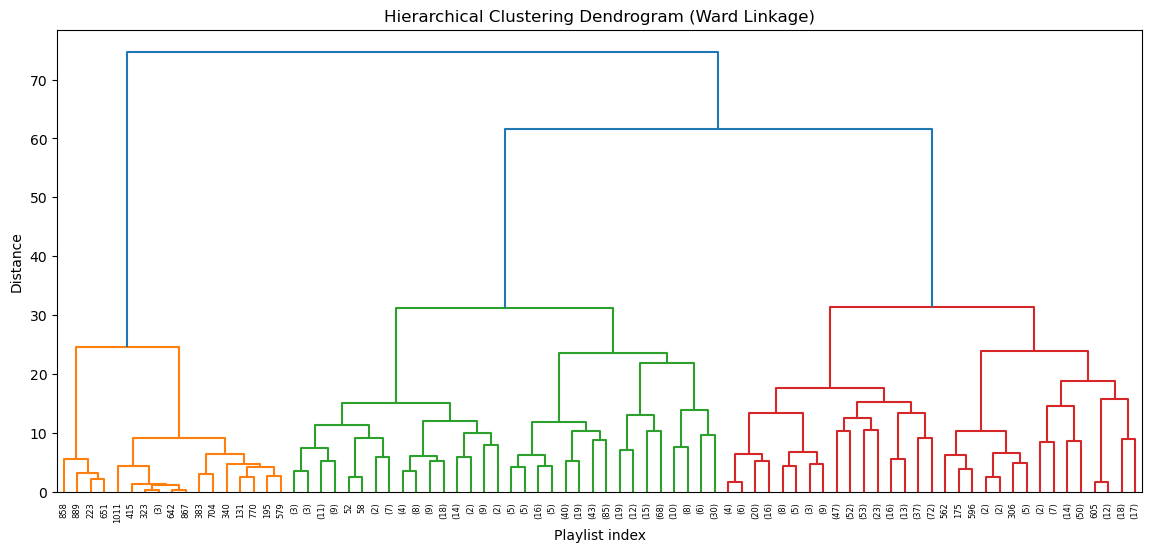

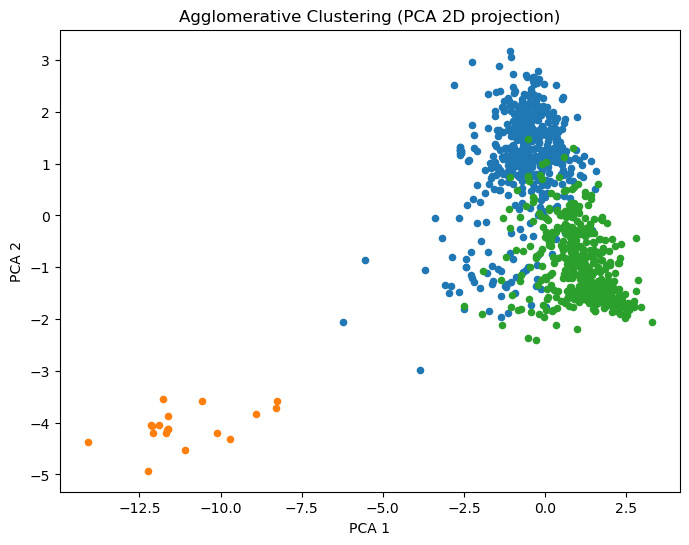

In [ ]:
hierarchical_clustering(X_imp)
plot_pca_agg(X_imp, 3)

Dropped NAs:

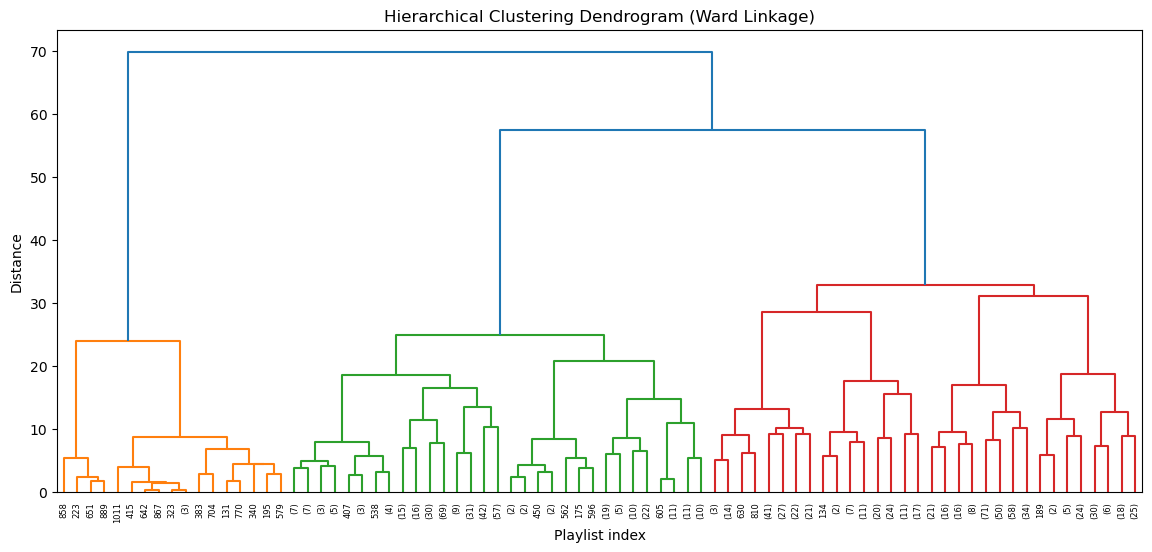

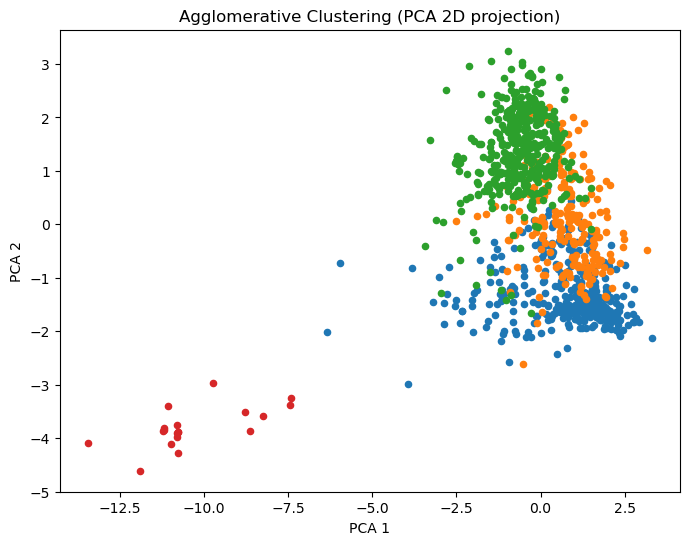

In [ ]:
hierarchical_clustering(X_drop)
plot_pca_agg(X_drop, 4)

This type of clustering is by itself not very interpretable, and it was more used to check about the choice of K. It yields results that agree on K-means and the clusters seem to be pretty much the same, even though K-means shows less overlap. Dendrogram shows that best K is either 3 or 4.

#### Clustering 3: DBSCAN (failed)

Imputed:


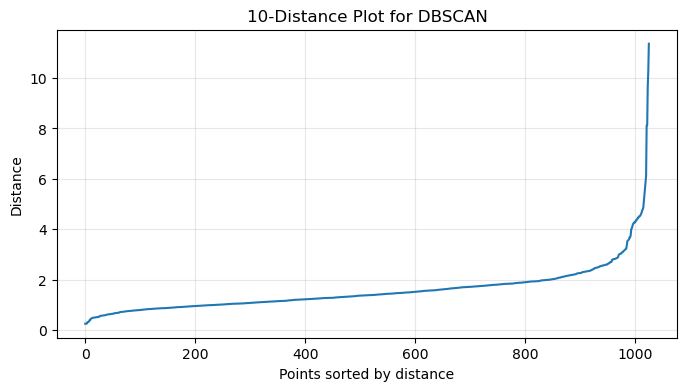

Dropped NAs:


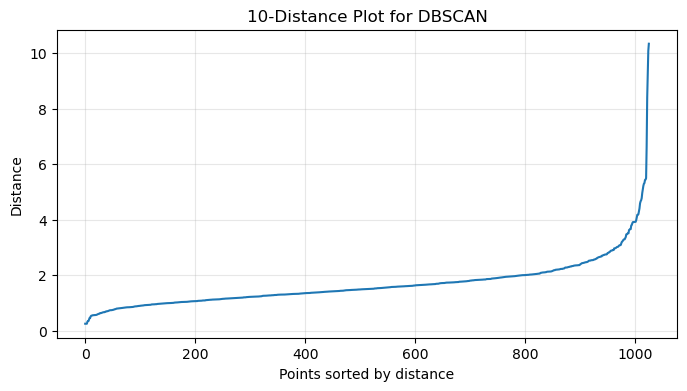

In [ ]:
def plot_k_distance(X, k=10):
   
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    
    # take the k-th distance, sort
    k_distances = np.sort(distances[:, -1])
    
    plt.figure(figsize=(8,4))
    plt.plot(k_distances)
    plt.title(f"{k}-Distance Plot for DBSCAN")
    plt.xlabel("Points sorted by distance")
    plt.ylabel("Distance")
    plt.grid(True, alpha=0.3)
    plt.show()

    return k_distances

print("Imputed:")
_ = plot_k_distance(X_imp)
print("Dropped NAs:")
_ = plot_k_distance(X_drop)

eps chosen at elbow: 2.5

Very high, DBSCAN is probably not going to work.

In [ ]:
def run_dbscan(X, eps, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = sum(labels == -1)
    
    print(f"DBSCAN found {n_clusters} clusters + {n_noise} noise points")
    
    return labels, db

eps = 2.5
labels_imp, db_imp = run_dbscan(X_imp, eps)
labels_drop, db_drop = run_dbscan(X_drop, eps)

DBSCAN found 1 clusters + 50 noise points
DBSCAN found 1 clusters + 57 noise points


DBSCAN does not work with this data set, further testing and analysis with this is pointless.

### 2.2 Genre-based clustering

Data preparation:

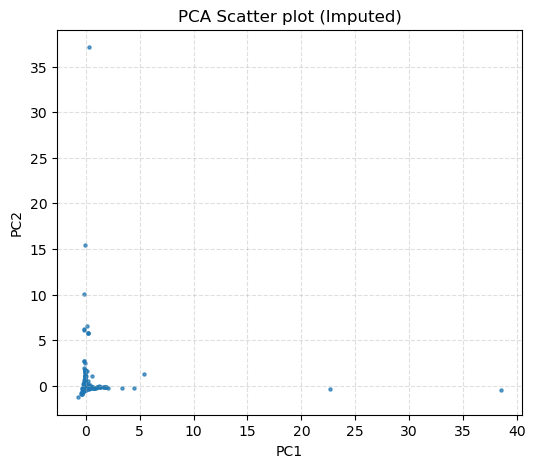

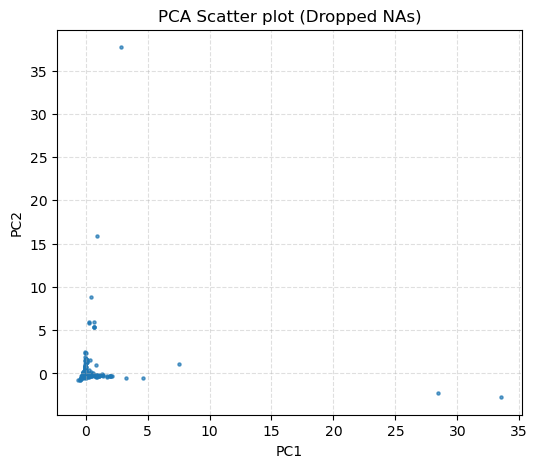

In [ ]:
#select columns
df_imp_genre = df_imp_all[genre_cols]
df_drop_genre = df_drop_all[genre_cols]

#scaling
df_imp_gsc = scale_features(df_imp_genre, genre_cols)
df_drop_gsc = scale_features(df_drop_genre, genre_cols)

#PCA
df_imp_gpca, _ = apply_pca(df_imp_gsc, n_components=0.90)
df_drop_gpca, _ = apply_pca(df_drop_gsc, n_components=0.90)

#visualisation
pca_plot(df_imp_gpca, "Imputed")
pca_plot(df_drop_gpca, "Dropped NAs")



The matrix is very sparse and that's why my PCA plots look like this but maybe it will get better.

K-Means:

In [ ]:

def plot_pca_3d(X, labels, title="PCA 3D Projection of Genre Clusters"):

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        X_pca[:,0], X_pca[:,1], X_pca[:,2],
        c=labels, cmap='tab10', s=20, alpha=0.8
    )
    
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(title)
    
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    
    plt.show()



def genre_kmeans_pipeline(X_genre, df_all, k_range=[3,4,5,6,7], best_k=None, top_n=5, plot_umap=True, plot_heatmap=True, random_state=SEED):
    
    results_sil = {}
    results_db = {}
    models = {}
    labels_dict = {}
    
    print("Running KMeans for multiple k:")
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state)
        labels = km.fit_predict(X_genre)
        sil = silhouette_score(X_genre, labels)
        db = davies_bouldin_score(X_genre, labels)
        
        results_sil[k] = sil
        results_db[k] = db
        models[k] = km
        labels_dict[k] = labels
        
        print(f"k={k}, silhouette={sil:.4f}, DB={db:.4f}")
    print()
    
    #best_k
    if best_k is None:
        best_k = max(results_sil, key=results_sil.get)
    print(f"Selected best_k = {best_k}")
    
    #best model
    best_model = models[best_k]
    best_labels = labels_dict[best_k]
    
    #cluster labels to dataframe
    df_all = df_all.copy()
    df_all['cluster_genre'] = best_labels
    
    #cluster sizes
    unique, counts = np.unique(best_labels, return_counts=True)
    print("\nCluster sizes:")
    for u, c in zip(unique, counts):
        print(f"Cluster {u+1}: {c} items")
    
    #summary / centroids
    cluster_summary = df_all.groupby('cluster_genre').mean()
    
    #dominant genres per cluster
    for cluster_id, row in cluster_summary.iterrows():
        print(f"\n=== Cluster {cluster_id+1} ===")
        non_zero_genres = row[row > 0]
        if non_zero_genres.empty:
            print("No genres present.")
            continue
        top_genres = non_zero_genres.sort_values(ascending=False).head(top_n)
        for genre, val in top_genres.items():
            print(f"{genre.replace('genre_', ''):20s} {val:.3f}")

    #pca plot
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X_genre)
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df_all['cluster_genre'], cmap='tab10', s=10)
    plt.title(f"PCA 2D Projection of Genre Clusters (k={best_k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    plot_pca_3d(X_genre, df_all['cluster_genre'])
    
    #centroid heatmap
    if plot_heatmap:
        plt.figure(figsize=(10,6))
        sns.heatmap(cluster_summary, annot=False, cmap="viridis")
        plt.title(f"Cluster Centroid Heatmap (k={best_k})")
        plt.xlabel("Genres")
        plt.ylabel("Cluster")
        plt.show()
    
    #UMAP visualization
    if plot_umap:
        reducer = umap.UMAP(random_state=random_state, init="random")
        embedding = reducer.fit_transform(X_genre)
        plt.figure(figsize=(7,5))
        plt.scatter(embedding[:,0], embedding[:,1], c=df_all['cluster_genre'], cmap='tab10', s=10)
        plt.title("UMAP Genre Clusters")
        plt.show()
    
    return {
        "best_k": best_k,
        "model": best_model,
        "labels": best_labels,
        "silhouette_scores": results_sil,
        "db_scores": results_db,
        "cluster_summary": cluster_summary
    }


Running KMeans for multiple k:
k=3, silhouette=0.5364, DB=0.9676
k=4, silhouette=0.5401, DB=1.2152
k=5, silhouette=0.5791, DB=1.2085
k=6, silhouette=0.6156, DB=1.2115
k=7, silhouette=0.6298, DB=1.1623

Selected best_k = 4

Cluster sizes:
Cluster 1: 380 items
Cluster 2: 216 items
Cluster 3: 343 items
Cluster 4: 87 items

=== Cluster 1 ===
hip-hop              0.877
dance                0.048
pop                  0.024
house                0.012
emo                  0.007

=== Cluster 2 ===
country              0.952
rock                 0.019
pop                  0.014
dance                0.005
alt-rock             0.003

=== Cluster 3 ===
alt-rock             0.160
pop                  0.156
rock                 0.146
emo                  0.058
metal                0.047

=== Cluster 4 ===
dance                0.694
pop                  0.085
hip-hop              0.077
electro              0.027
country              0.015


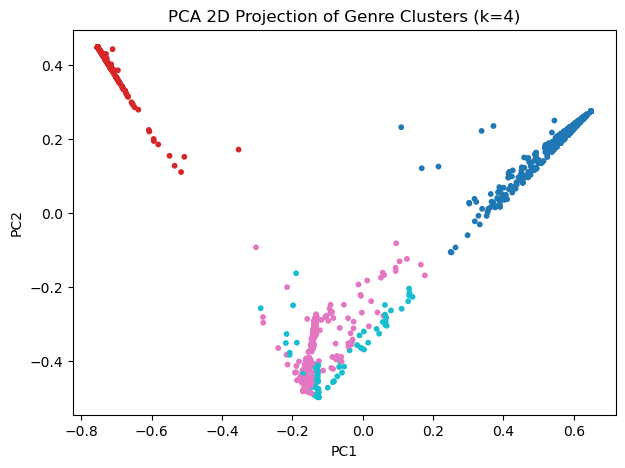

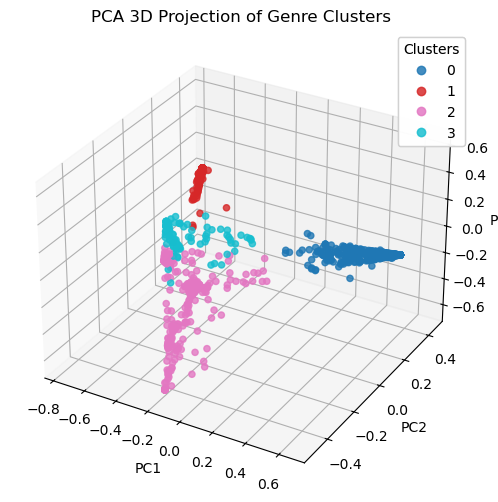

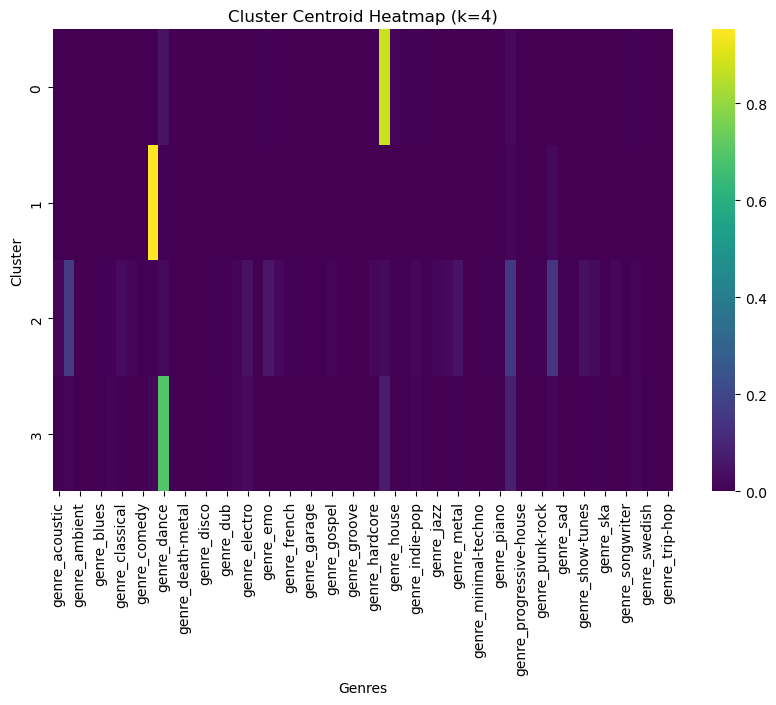

c:\Users\lunka\miniforge3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


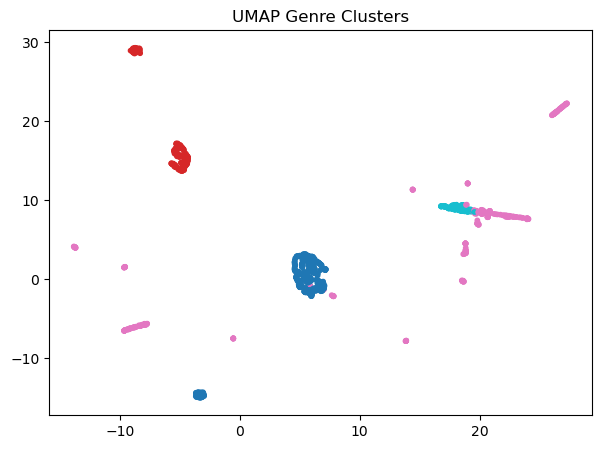

In [ ]:
results_genre_imp = genre_kmeans_pipeline(df_imp_genre, df_imp_genre, best_k=4)

Running KMeans for multiple k:
k=3, silhouette=0.5062, DB=1.0036
k=4, silhouette=0.4924, DB=1.3215
k=5, silhouette=0.5282, DB=1.2752
k=6, silhouette=0.5535, DB=1.2914
k=7, silhouette=0.5825, DB=1.3054

Selected best_k = 4

Cluster sizes:
Cluster 1: 379 items
Cluster 2: 215 items
Cluster 3: 348 items
Cluster 4: 84 items

=== Cluster 1 ===
hip-hop              0.848
dance                0.059
pop                  0.028
house                0.015
emo                  0.010

=== Cluster 2 ===
country              0.943
rock                 0.024
pop                  0.016
dance                0.006
alt-rock             0.003

=== Cluster 3 ===
alt-rock             0.154
pop                  0.150
rock                 0.141
emo                  0.054
metal                0.047

=== Cluster 4 ===
dance                0.639
pop                  0.118
hip-hop              0.096
electro              0.024
soul                 0.017


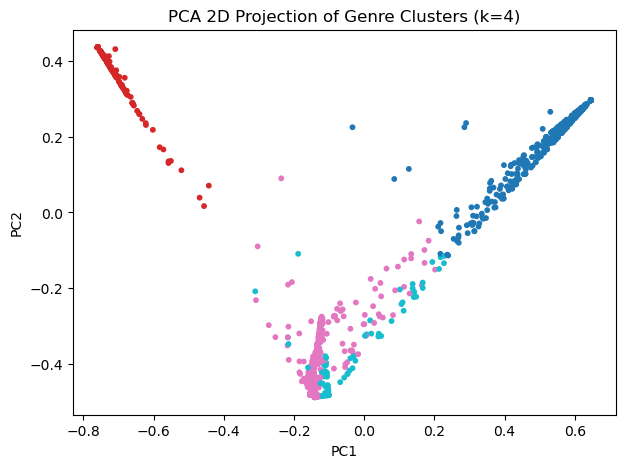

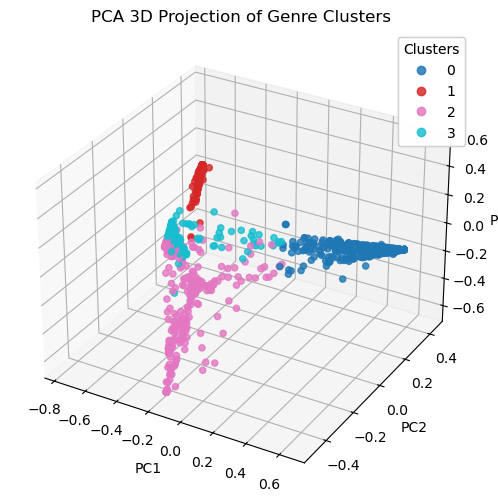

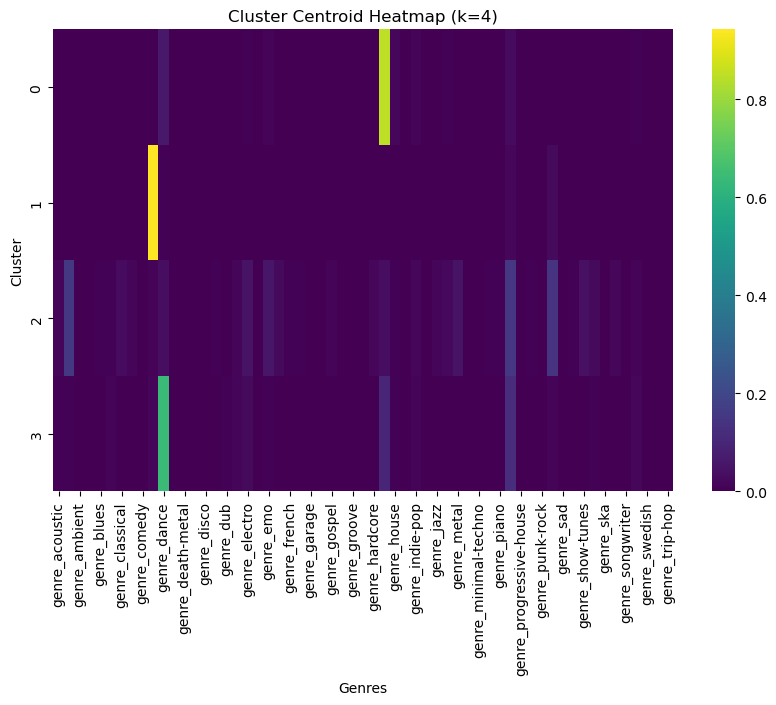

c:\Users\lunka\miniforge3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


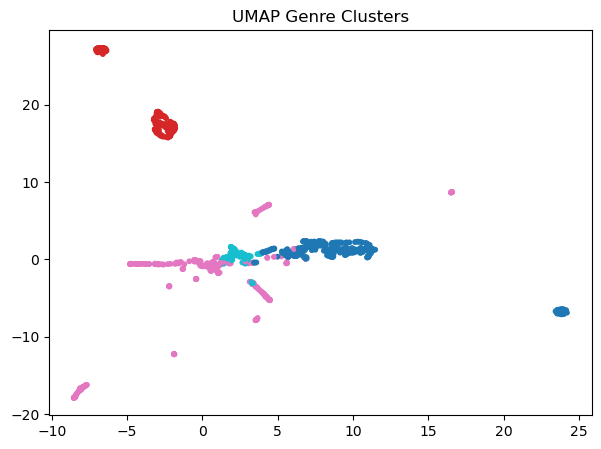

In [ ]:
results_genre_drop = genre_kmeans_pipeline(df_drop_genre, df_drop_genre, best_k=4)

Comparing the two KMeans runs, both selected best_k = 4, but the clusters differ in structure and cohesion. In the first run, silhouette scores were generally higher (up to 0.6057), indicating tighter, more well-separated clusters, while the second run had lower silhouette scores (up to 0.5540), suggesting slightly less distinct separation.

The cluster sizes also differ: the first run had a small alternative rock cluster (44 playlists) and a moderate country cluster (191), whereas in the second run, the country cluster became larger (189), the pop cluster expanded (403), and a small show-tunes/jazz cluster emerged (22 playlists).

Looking at dominant genres, the first run’s clusters were clearer in thematic separation:

Cluster 1: pop/dance/rock

Cluster 2: country

Cluster 3: alt-rock/rock

Cluster 4: hip-hop

In the second run, clusters mix some genres more:

Cluster 1: pop/dance/alt-rock/rock

Cluster 2: hip-hop/dance/pop

Cluster 3: show-tunes/jazz

Cluster 4: country

Overall, the first clustering appears more interpretable with distinct genre focus per cluster, while the second clustering produces slightly more mixed clusters but captures niche genres like show-tunes and jazz. Depending on the application—recommendation vs. exploration—the first run may provide cleaner genre-based separation, while the second run may highlight minor niche clusters.

### 2.3 Text-based clustering (playlist name)

Data load:

In [ ]:
df_text = pd.read_csv("data/data_text.csv")
df_text = df_text[['playlist_id', 'playlist_name']]

TD-IDF and K-means:

In [ ]:
#TF-IDF: names to vectors
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,        
    ngram_range=(1,2)          
)

X_tfidf = vectorizer.fit_transform(df_text['playlist_name'])


#KMEANS
sil_scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=1234)
    labels = km.fit_predict(X_tfidf)
    sil = silhouette_score(X_tfidf, labels)
    sil_scores[k] = sil
    print(k, sil)

2 0.09808804272445448
3 0.12069591274606195
4 0.16924802064975936
5 0.17353077444788365
6 0.1761523778981683
7 0.20521040346740926
8 0.21098868365994772
9 0.2190117790225656


Interpretation of different ks:\
It cannot really be chosen by score, because it will keep increasing as I increase k, so I am focusing more on impretablity.\
Big improvement from 3 to 5, very small changes from 5 to 6 and then probably overfitting. K's bigger than 6 would probably make too specific clusters and they would capture a lot of noise and meaningless words.


In [ ]:
#terms ranked by importance for the 4 considered ks
for k_try in [3, 4, 5, 6]:
    km = KMeans(n_clusters=k_try, random_state=SEED)
    labels = km.fit_predict(X_tfidf)
    centers = km.cluster_centers_
    terms = vectorizer.get_feature_names_out()

    print(f"\nk={k_try}")
    for i in range(k_try):
        top = centers[i].argsort()[::-1][:8]
        print(f"Cluster {i}: {[terms[j] for j in top]}")


k=3
Cluster 0: ['pop', 'pop hits', '2025', 'hits', 'girlies', 'pop girlies', 'hits 2015', '2015 2025']
Cluster 1: ['country', 'country music', 'music', 'øne piløts', 'famous', 'favorites', 'favorite songs', 'favorite']
Cluster 2: ['hip hop', 'hop', 'hip', 'det', 'fandme', 'det fandme', 'fandme hip', 'rock']

k=4
Cluster 0: ['pop girlies', 'girlies', 'pop', 'øne piløts', 'fake love', 'favorite songs', 'favorite', 'faves']
Cluster 1: ['country', 'øne piløts', 'favs', 'favorites', 'favorite songs', 'favorite', 'faves', 'fave']
Cluster 2: ['det fandme', 'fandme', 'fandme hip', 'det', 'hop', 'hip', 'hip hop', 'empire']
Cluster 3: ['rock', 'pop', 'musik', 'rock musik', 'hits', 'music', 'country', '2025']

k=5
Cluster 0: ['pop girlies', 'girlies', 'pop', 'øne piløts', 'fake love', 'favorite songs', 'favorite', 'faves']
Cluster 1: ['country', 'øne piløts', 'favs', 'favorites', 'favorite songs', 'favorite', 'faves', 'fave']
Cluster 2: ['det fandme', 'fandme', 'fandme hip', 'det', 'hop', 'hip',

In [ ]:
#FINAL MODEL ON K = 5

km_5 = KMeans(n_clusters=5, random_state=1234)
labels = km_5.fit_predict(X_tfidf)
centers = km_5.cluster_centers_
terms = vectorizer.get_feature_names_out()

unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u+1}: {c} items")

Cluster 1: 1010 items
Cluster 2: 3815 items
Cluster 3: 2817 items
Cluster 4: 36305 items
Cluster 5: 260 items


Visualization:

Text(0.5, 1.0, 'Playlist Title Clusters after t-SNE')

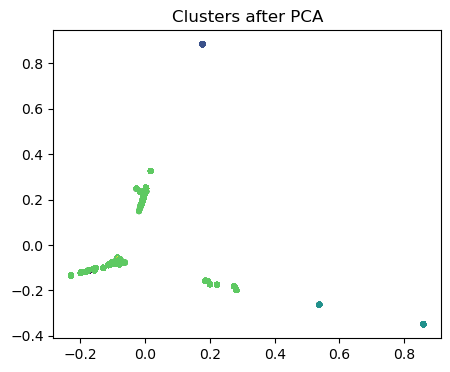

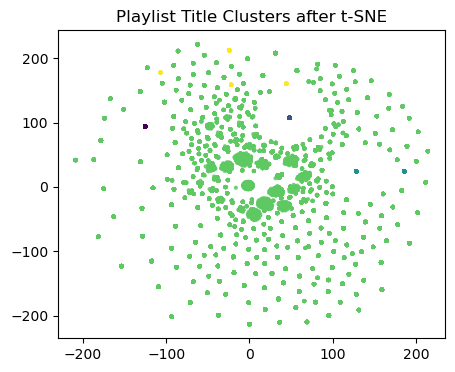

In [ ]:
#dimensionality reduction
pca = PCA(n_components=0.90, random_state=1234)
X_pca = pca.fit_transform(X_tfidf.toarray())

tsne = TSNE(n_components=2, perplexity=30, random_state=1234)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    X_pca[:, 1],
    X_pca[:, 0],
    c=labels,
    cmap="viridis",
    s=10,
    alpha=0.8
)
plt.title("Clusters after PCA")

plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    X_tsne[:, 1],
    X_tsne[:, 0],
    c=labels,
    cmap="viridis",
    s=4,
    alpha=0.8
)
plt.title("Playlist Title Clusters after t-SNE")

Clusters are highly imbalanced as cluster 2 contains more than 80% of all playlists. Playlist titles are too short and random/uninformative and are not useful for genre separation or recommendation. In the visualisations it is also clear that clustering was very unsuccessful.